# GOES animation tutorial
A quick tutorial to load GOES-16 ABI images from GCS, create RGB images and create an animated video of a day of ABI full disc observations

Note: downloading GOES data using the google cloud api requires you to have GCP service account credentials set up (https://console.cloud.google.com/apis/credentials/serviceaccountkey), and the environment variable GOOGLE_APPLICATION_CREDENTIALS set as the path to your service account key. See https://cloud.google.com/docs/authentication/getting-started for more details

Required modules (from conda):
google-cloud-storage numpy pandas xarray netcdf4 python-dateutil matplotlib ffmpeg 

Optional modules:
imagemagick (for creating a gif)

In [1]:
import os
import sys
import inspect

import subprocess
from glob import glob
from google.cloud import storage
import warnings

import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
from dateutil.parser import parse as parse_date

import matplotlib.pyplot as plt
from matplotlib import animation

# code from https://stackoverflow.com/questions/279237/import-a-module-from-a-relative-path?lq=1#comment15918105_6098238 to load a realitive folde from a notebook
# realpath() will make your script run, even if you symlink it :)
cmd_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0]))
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)

from utils.io import *

Define local path to the data download location

In [7]:
data_path = '/gws/nopw/j04/eo_shared_data_vol2/scratch/satellite/GOES16/MCMIPF'

Run test functions for GCP download functions

In [8]:
test_find_abi_blobs()
test_download_goes_blobs()
test_get_goes_date()
test_find_abi_files()
test_find_glm_blobs()
test_find_glm_files()

In [9]:
dates = list(pd.date_range(datetime(2020,7,1,5), datetime(2020,7,2,4), freq='h').to_pydatetime())
print(dates[0], dates[-1])

2020-07-01 05:00:00 2020-07-02 04:00:00


Download a day of full disk CMI (cloud and moisture imagery) data.

Note that this is about 46GB, so it may take some time and is recommended that you run this on a remote server

In [10]:
abi_files = []
for date in dates:
    abi_files.extend(find_abi_files(date, satellite=16, product='MCMIP', view='F', mode=6, 
                               save_dir=data_path, 
                               replicate_path=True, check_download=True, 
                               n_attempts=1, download_missing=True))


In [11]:
len(abi_files) #Should be 144 for a full day of mode 6 (10 minute full disk)

144

In [12]:
abi_files = sorted(abi_files)

Functions to create RGB imagery using GOES ABI. ABI doesn't have a green channel, so we have to reconstruct it using the 0.86 micron near-IR channel (which is sensitive to vegetation) and the red and blue visible channels (credit: http://edc.occ-data.org/goes16/python/)

In [13]:
def _contrast_correction(color, contrast):
    """
    Modify the contrast of an R, G, or B color channel
    See: #www.dfstudios.co.uk/articles/programming/image-programming-algorithms/image-processing-algorithms-part-5-contrast-adjustment/
    Input:
        C - contrast level
    """
    F = (259*(contrast + 255))/(255.*259-contrast)
    COLOR = F*(color-.5)+.5
    COLOR = np.minimum(COLOR, 1)
    COLOR = np.maximum(COLOR, 0)
    return COLOR

def get_abi_rgb(C01, C02, C03, gamma=0.4, contrast=100):
    R = np.maximum(C02, 0)
    R = np.minimum(R, 1)
    G = np.maximum(C03, 0)
    G = np.minimum(G, 1)
    B = np.maximum(C01, 0)
    B = np.minimum(B, 1)
    R = np.power(R, gamma)
    G = np.power(G, gamma)
    B = np.power(B, gamma)
    G_true = 0.48358168 * R + 0.45706946 * B + 0.06038137 * G
    G_true = np.maximum(G_true, 0)
    G_true = np.minimum(G_true, 1)
    RGB = _contrast_correction(np.stack([R, G_true, B], -1), contrast=contrast)
    return RGB


Test one image

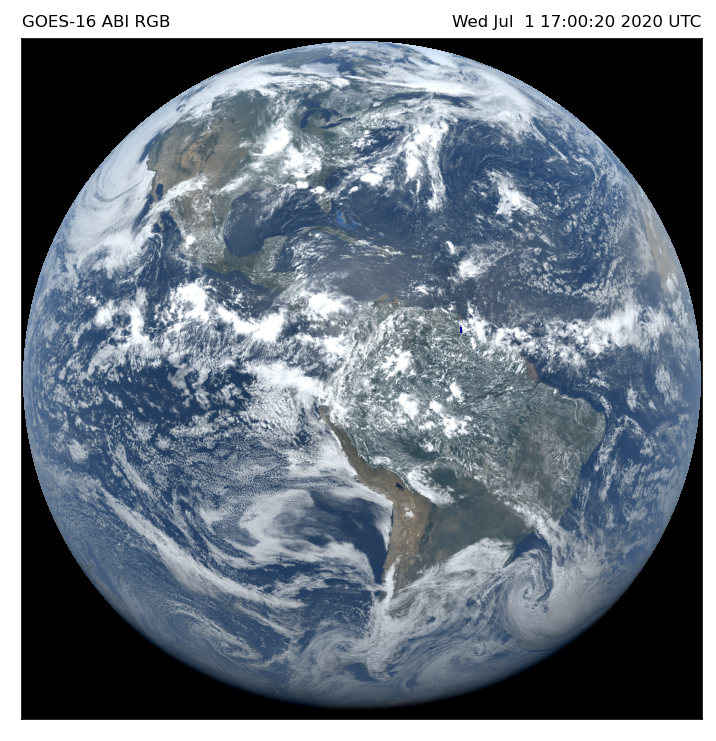

In [14]:
with xr.open_mfdataset([abi_files[72]], combine='nested', concat_dim='t') as ds:
    rgb = get_abi_rgb(ds.CMI_C01[0], ds.CMI_C02[0], ds.CMI_C03[0])

plt.figure(dpi=150, figsize=(6,6))
img = plt.imshow(rgb)
plt.xticks([])
plt.yticks([])
t1 = plt.title('GOES-16 ABI RGB', loc='left', size=8)
t2 = plt.title(get_goes_date(abi_files[72]).ctime()+' UTC', loc='right', size=8)

In [15]:
img_shape = rgb.shape
img_shape

(5424, 5424, 3)

Now let's animate an entire day

Step 1: Set up the plot; define a figure (with handle), and any axes and objects you want to plot

In [39]:
%%capture
fig = plt.figure(dpi=150, figsize=(6,6))

img = plt.imshow(np.zeros(img_shape))
plt.xticks([])
plt.yticks([])
t1 = plt.title('GOES-16 ABI RGB', loc='left', size=8)
t2 = plt.title('', loc='right', size=8)


Step 2: Define an initiation function; this needs to return the plotting handles of the elements you wish to animate

In [40]:
# init function: returns the plotting handles that will be modified
def init():
    img.set_data(np.zeros(img_shape))
    t2.set_text('')
    return img, t2


Step 3: Define an animation function, which modifies the plot handles returned in the prior init function. This takes an integer of the frame index, and returns the same plot handles defined before. Normally it is best practice to change the data of the plot in place using .set_data (or .set_text for titles and othe text), but for some plots (e.g. plotting using cartopy projections) you may have to redefine the plot.

In [41]:
# animation function: modifies the data of the plot handles according to a frame index
def animate(i):
    with xr.open_dataset(abi_files[i]) as dsi:
        rgbi = get_abi_rgb(dsi.CMI_C01, dsi.CMI_C02, dsi.CMI_C03)
        img.set_data(rgbi)
        t2.set_text(get_goes_date(abi_files[i]).ctime()+' UTC')
    return img, t2


Step 4: Call FuncAnimation using the figure handle defined in step 1, the animate function defined in step 3 and the init function defined in step 2. Set the number of frames using the frames keyword. Using blit improved efficiency by only changing modified pixels

In [42]:
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(abi_files), 
                               interval=20, blit=True)


Embedding the animation or saving as a video/gif is where the real work is, so this runs quite slow

In [43]:
# Embed using ipython
from IPython.display import HTML, Image, display
HTML(anim.to_html5_video())

In [ ]:
# Save animation as an mp4 video
anim.save('~/goes_animation_20200701.mp4', fps=30, 
          extra_args=['-vcodec', 'libx264'])


In [ ]:
# Save animation as a gif
anim.save('~/goes_animation_20200701.gif', fps=30, 
          writer='imagemagick')


In [9]:
# GOES-17
dates = list(pd.date_range(datetime(2020,7,1,16), datetime(2020,7,1,17), freq='h').to_pydatetime())
print(dates[0], dates[-1])

2020-07-01 16:00:00 2020-07-01 17:00:00


In [11]:
abi_files = []
for date in dates:
    abi_files.extend(find_abi_files(date, satellite=17, product='MCMIP', view='F', mode=6, 
                               save_dir=data_path, 
                               replicate_path=True, check_download=True, 
                               n_attempts=1, download_missing=True))


In [12]:
abi_files = sorted(abi_files)

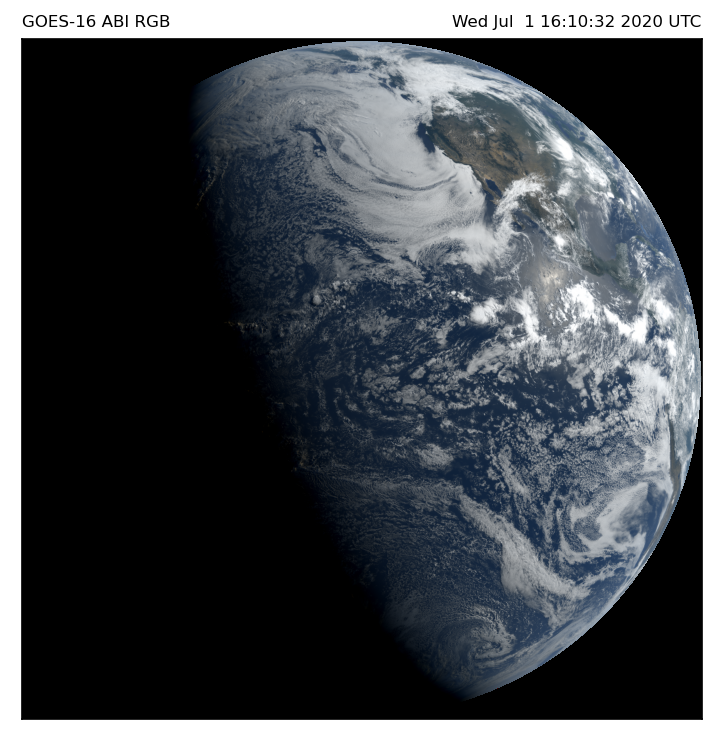

In [18]:
with xr.open_mfdataset([abi_files[1]], combine='nested', concat_dim='t') as ds:
    rgb = get_abi_rgb(ds.CMI_C01[0], ds.CMI_C02[0], ds.CMI_C03[0])

plt.figure(dpi=150, figsize=(6,6))
img = plt.imshow(rgb)
plt.xticks([])
plt.yticks([])
t1 = plt.title('GOES-16 ABI RGB', loc='left', size=8)
t2 = plt.title(get_goes_date(abi_files[1]).ctime()+' UTC', loc='right', size=8)